In [1]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import skimage.morphology as skm

from keras import backend as K
K.set_image_dim_ordering('tf') # order channels by tensorflow

from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam

# Acknowledgements: Keras and Tensorflow Documentation, Anuj Shah and Siraj Ravel

Using TensorFlow backend.


In [6]:
# Define data path
data_path = '/Convolution/sample'
data_dir_list = os.listdir(data_path) #Folders

#grayscale, tophat+grayscale, 2 tophat+grayscale, tophat color, and just color (original image)

# Define image size to feed into network
img_rows=128
img_cols=128

img_data_list=[]

# Go through folders of pictures
for dataset in data_dir_list:
    # filter out hidden files
    if not dataset.startswith('.'):    
        img_list = os.listdir(data_path + '/' + dataset)
        print('Loading dataset')
        # in each image in each folder: read it, manipulate it, and append it to list
        for img in img_list:
            try:
                # filter hidden files
                if not img.startswith('.'):
                    input_img = cv2.imread(data_path + '/' + dataset + '/' + img) # read
                    
                    #input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY) # convert to grayscale
                    
                    #black tophat approach (1 and 2 rounds)
                    black_tophat = skm.black_tophat(input_img)
                    black_tophat2 = skm.black_tophat(black_tophat)
                    input_img = cv2.cvtColor(black_tophat2, cv2.COLOR_BGR2GRAY) # convert tophat to grayscale

                    #convert to binary (not the best, made entire img blob occasionaly)
                    #(thresh, im_bw) = cv2.threshold(input_img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

                    input_img_resize = cv2.resize(input_img,(128, 128)) # resize (use im_bw if binary, input_img otherwise)
                    img_data_list.append(input_img_resize) # append to list
            except Exception as e:
                print(e)
print('done')

Loading dataset
Loading dataset
done


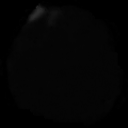

In [7]:
# Examining images

from PIL import Image
im_gray = img_data_list[300]

#testing binary
#(thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

Image.fromarray(im_gray)

In [8]:
img_data = np.array(img_data_list) # convert into an array
img_data = img_data.astype('float32') # convert into a float
img_data /= 255 # normalize
print (img_data.shape)

#reshape backend for tensorflow, 
#start at axis=4: ordering of samples, channels, rows, and columns
img_data= np.expand_dims(img_data, axis=4) # didnt expand dimensions for color to keep the 4 dimensions

(2000, 128, 128)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


In [9]:
# Assigning Labels

# Define the number of classes (Parasitized, Uninfected)
num_classes = 2

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:1000]=1 #Parasitized
labels[1000:]=0 #Uninfected

names = ['Parasitized','Uninfected']
# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

# Shuffle the dataset, random state gives a fixed value of shuffling
x,y = shuffle(img_data,Y, random_state=2)
# train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
print('done')

done


In [10]:
# Building the convolutional neural network

input_shape=img_data[0].shape #for grayscale
#input_shape=(128, 128, 3) #for color 
model = Sequential()

# for first convolutional layer we use 32 filters, 3x3 rows by columns
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=input_shape))
model.add(Activation('relu')) #relu

# second layer layer
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # max pooling of size 2x2
model.add(Dropout(0.5)) # Dropout to avoid overfitting

# Flatten into an open one dimensional vector which becomes our feature vector to feed into the fully connected layer
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# number of classes is 2
model.add(Dense(num_classes))
# softmax regression
model.add(Activation('softmax'))

# compile by giving a loss function:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(128, 128,..., padding="same")`
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  if sys.path[0] == '':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 127008)            0         
__________

In [20]:
# Train the model

#grayscale is 1 channel 3 channels is rgb
num_channel=1
num_epoch=20 # only 20 epochs so did 16 batches
batch_size = 16 

hist = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=num_epoch, verbose=1, validation_data=(X_test, y_test))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 88s 55ms/step - loss: 0.6292 - acc: 0.6244 - val_loss: 0.5960 - val_acc: 0.6575
Epoch 2/20
1600/1600 [==============================] - 82s 52ms/step - loss: 0.6025 - acc: 0.6550 - val_loss: 0.5923 - val_acc: 0.6275
Epoch 3/20
1600/1600 [==============================] - 82s 52ms/step - loss: 0.6034 - acc: 0.6556 - val_loss: 0.5490 - val_acc: 0.8200
Epoch 4/20
1600/1600 [==============================] - 83s 52ms/step - loss: 0.5543 - acc: 0.7056 - val_loss: 0.5284 - val_acc: 0.6325
Epoch 5/20
1600/1600 [==============================] - 82s 51ms/step - loss: 0.5204 - acc: 0.7469 - val_loss: 0.5274 - val_acc: 0.9075
Epoch 6/20
1600/1600 [==============================] - 80s 50ms/step - loss: 0.4668 - acc: 0.8000 - val_loss: 0.4963 - val_acc: 0.6775
Epoch 7/20
1600/1600 [==============================] - 83s 52ms/step - loss: 0.4548 - acc: 0.8187 - val_loss: 0.4205 - val_acc: 0.6500
E

In [11]:
#save model
#model.save('Convolution/model/my_model.h5')

# returns saved model using 2 rounds of black top hat (94.25% accuracy)
model = load_model('/Users/Administrator/Desktop/Convolution/model/two_tophat_grayscale.h5')


In [12]:
# Printing the confusion matrix and evaluating accuracy
from sklearn.metrics import classification_report,confusion_matrix
import itertools

#test loss and accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

target_names = ['class 0(uninfected)', 'class 1(parasitized)']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))


Test Loss: 0.3216337168216705
Test accuracy: 0.9425
                      precision    recall  f1-score   support

 class 0(uninfected)       0.92      0.97      0.94       201
class 1(parasitized)       0.96      0.92      0.94       199

           micro avg       0.94      0.94      0.94       400
           macro avg       0.94      0.94      0.94       400
        weighted avg       0.94      0.94      0.94       400

[[194   7]
 [ 16 183]]
